<a href="https://colab.research.google.com/github/WadeShadow/nlp2021/blob/main/Exam/Brekht.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Брехт Андрій Олексійович
---
### Група: ТШІ-21
### Варіант: 2
---
### Практичне завдання іспиту з дисципліни "Методи обробки природномовної інформації"
### Дата складання: 13.12.2021р.

---
Варіант № 2

Завдання:
Розробити Jupyter Notebook для вирішення завдання класифікації тексту
на основі набору даних:
https://drive.google.com/drive/folders/1cYLsyazwxMUSICumvIhv5jGJe6K7iAHa?usp=sharing

Забезпечити виконання наступних етапів:
1. Завантаження та попередній аналіз даних.
2. Створення тренувального та тестувального наборів даних.
3. Попередню оцінку точності моделі за допомогою методу Naive Bayes.
4. Вирішення задачі класифікації за допомогою методу GRU model.
5. Графічне відображення тренування моделі.
6. Порівняння результатів, отриманих у п.п. 3,4
7. Висновки.

Структура звітного документу:
Заголовок роботи (Markdown: П.І.Б., група, назва роботи (Практичне завдання іспиту з дисципліни...), дата складання.)
Етапи роботи (Номер та назва етапу (частини етапу),  код з коментарями.)

Використати технології: Tensorflow, Google Colab.
Результати викласти у форматі Brekht.ipynb у папку Exam репозиторію GitHub.

#Завантаження та попердній аналіз даних

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf, requests as rqst, io
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

rnd = np.random.randint

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

--2021-12-13 08:14:14--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-12-13 08:14:14 (68.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
file = open('train_new.csv','r')
new_file = open('train_new1.csv', 'w')
for i, line in enumerate(file):
  if i>930 and i<940:
    continue
  new_file.write(line)

In [ ]:
training_data = pd.read_csv('train.csv', engine='python', error_bad_lines=False)
val_data = pd.read_csv('valid.csv', engine='python', error_bad_lines=False)
training_data
val_data

Skipping line 937: unexpected end of data
Skipping line 1017: unexpected end of data


,Id,Title,Body,Tags,CreationDate,Y
0,34552974,How to get all the child records from differen...,I am having 4 different tables like \r\nselect...,<sql><sql-server>,2016-01-01 01:44:52,LQ_EDIT
1,34554721,Retrieve all except some data of the another t...,I have two table m_master and tbl_appointment\...,<php><mysql><sql><codeigniter><mysqli>,2016-01-01 08:43:50,LQ_EDIT
2,34555135,Pandas: read_html,<p>I'm trying to extract US states from wiki U...,<python><pandas>,2016-01-01 09:55:22,HQ
3,34555448,Reader Always gimme NULL,"I'm so new to C#, I wanna make an application ...",<sql-server><c#-4.0>,2016-01-01 10:43:45,LQ_EDIT
4,34555752,php rearrange array elements based on condition,basically i have this array:\r\n\r\n array(...,<php>,2016-01-01 11:34:09,LQ_EDIT
...,...,...,...,...,...,...
1010,35745067,regex extract a text between string,<p>are not so expert with regex\ni have this s...,<regex><vb.net>,2016-03-02 10:50:27,LQ_CLOSE
1011,35747862,what does _doc represents in elasticsearch?,<p>I am still trying to figure out what does _...,<elasticsearch>,2016-03-02 12:56:10,HQ
1012,35748116,Babel ignore several directories,<p>I'm currently running Babel with a simple c...,<javascript><babeljs>,2016-03-02 13:07:57,HQ
1013,35750407,PHP Sanitise Data,<p>Can't seem to sanitise php data</p>\n\n<pre...,<php><mysql>,2016-03-02 14:44:23,LQ_CLOSE


In [ ]:
training_data['Predict'] = training_data['Y']
val_data['Predict'] = val_data['Y']

training_data.replace({'Predict':{'LQ_EDIT':0,'HQ':1, 'LQ_CLOSE':2}}, inplace=True)
val_data.replace({'Predict':{'LQ_EDIT':0,'HQ':1, 'LQ_CLOSE':2}}, inplace=True)
training_data

,Id,Title,Body,Tags,CreationDate,Y,Predict
0,34552656,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,2016-01-01 00:21:59,LQ_CLOSE,2
1,34553034,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,2016-01-01 02:03:20,HQ,1
2,34553174,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,2016-01-01 02:48:24,HQ,1
3,34553318,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,2016-01-01 03:30:17,HQ,1
4,34553755,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,<android><material-design><floating-action-but...,2016-01-01 05:21:48,HQ,1
...,...,...,...,...,...,...,...
930,34892541,"Notice ""Undifined Variable""","<p>I am running a PHP script, and keep getting...",<php>,2016-01-20 05:57:59,LQ_CLOSE,2
931,34892601,what does the weak_alias function do and where...,<p>So I'm looking through the source of gcc co...,<c><linux><gcc><compiler-construction><gnu>,2016-01-20 06:02:20,HQ,1
932,34892696,how to show selected item in another activityi...,<p>I am new in android. My app is basically is...,<android>,2016-01-20 06:08:02,LQ_CLOSE,2
933,34893279,Spring Data Redis Expire Key,<p>I have a One Spring Hibernate Application. ...,<java><spring><hibernate><redis>,2016-01-20 06:49:25,HQ,1


#Створення тренувального та тестувального наборів даних + Векторизація та Ембедінг

In [ ]:
train_set = training_data[['Body','Predict']].sample(frac=1)
val_set = val_data[['Body','Predict']].sample(frac=1)
train_set

,Body,Predict
470,<p>I was wondering if it was possible in Java ...,2
211,def one_good_turn(n):\r\n return n + 1\r\n ...,0
431,im new at coding cpp and i dont undertstand ho...,0
140,<p>I tried to do a program that random 10000 n...,2
321,<p>Im making an app/game in android studio. An...,2
...,...,...
880,I have this :\r\n\r\n #include <stdio.h>\r\...,0
681,<p>My Jenkins box needs to access Stash and Ji...,1
412,"<p>I have a global variable ""count"". All I wan...",2
186,"<p>I am having problem with my ios air app, sh...",2


In [ ]:
avg_length = round(sum([len(i.split()) for i in train_set['Body']])/len(train_set))
avg_length

113

In [ ]:
max_vocab_length = 10000

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=avg_length)

text_vectorizer.adapt(train_set['Body'])

text_vectorizer(train_set['Body'])

<tf.Tensor: shape=(935, 113), dtype=int64, numpy=
array([[  18,   98,  441, ...,    0,    0,    0],
       [ 267,    1,   42, ...,    0,    0,    0],
       [  58,   36,   34, ..., 2043, 1519, 2042],
       ...,
       [  18,   16,    5, ...,    0,    0,    0],
       [  18,   28,  346, ...,    0,    0,    0],
       [  58, 1017,   91, ...,    0,    0,    0]])>

In [ ]:
embedding = layers.Embedding(input_dim=max_vocab_length, 
                             output_dim=128, 
                             embeddings_initializer="uniform",
                             input_length=avg_length) 

embedding(text_vectorizer(train_set['Body']))

<tf.Tensor: shape=(935, 113, 128), dtype=float32, numpy=
array([[[ 0.00653668,  0.01393073,  0.02282676, ..., -0.03057443,
          0.01435179, -0.01437119],
        [-0.00830965,  0.03968051, -0.03321201, ...,  0.02701988,
         -0.00878114,  0.03636404],
        [-0.03674699,  0.00494296,  0.03363765, ...,  0.01554285,
         -0.03965672,  0.04102136],
        ...,
        [ 0.00623541, -0.03515131, -0.04980059, ...,  0.01085637,
         -0.0125587 ,  0.04800088],
        [ 0.00623541, -0.03515131, -0.04980059, ...,  0.01085637,
         -0.0125587 ,  0.04800088],
        [ 0.00623541, -0.03515131, -0.04980059, ...,  0.01085637,
         -0.0125587 ,  0.04800088]],

       [[ 0.02702696, -0.03015264,  0.04243927, ..., -0.00235766,
         -0.04499655, -0.04163764],
        [ 0.04502426, -0.04832106,  0.0063551 , ...,  0.04780358,
          0.03976606, -0.00373094],
        [-0.03683449,  0.0210145 , -0.02751356, ..., -0.04111754,
          0.00322573,  0.04403928],
        ..

#Попередню оцінка точності моделі за допомогою методу Naive Bayes.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([("tfidf", TfidfVectorizer()), ("clf", MultinomialNB())])

model_0.fit(train_set['Body'], train_set['Predict'])

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
baseline_score = model_0.score(val_set['Body'], val_set['Predict'])
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 44.53%


In [ ]:
baseline_preds = model_0.predict(val_set['Body'])
baseline_preds

array([1, 1, 1, ..., 1, 1, 1])

#Вирішення задачі класифікації за допомогою методу GRU

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [ ]:
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(128)(x)
x = layers.Dense(128, activation="sigmoid")(x) 
outputs = layers.Dense(3, activation="softmax")(x)
model_gru = tf.keras.Model(inputs, outputs, name="model_GRU")

In [ ]:
model_gru.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_gru.summary()

Model: "model_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 113)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 113, 128)          1280000   
                                                                 
 gru_1 (GRU)                 (None, 128)               99072     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 3)                 387       
                                                         

In [ ]:
model_gru_history = model_gru.fit(train_set['Body'], train_set['Predict'],
                              epochs=30,
                              validation_data=(val_set['Body'], val_set['Predict']))

Epoch 1/30
30/30 [==============================] - 4s 67ms/step - loss: 0.9892 - accuracy: 0.4866 - val_loss: 1.0138 - val_accuracy: 0.4621
Epoch 2/30
30/30 [==============================] - 1s 49ms/step - loss: 0.5041 - accuracy: 0.7487 - val_loss: 1.2031 - val_accuracy: 0.4759
Epoch 3/30
30/30 [==============================] - 1s 49ms/step - loss: 0.4073 - accuracy: 0.7754 - val_loss: 1.3493 - val_accuracy: 0.5340
Epoch 4/30
30/30 [==============================] - 1s 49ms/step - loss: 0.4002 - accuracy: 0.7850 - val_loss: 1.1947 - val_accuracy: 0.5547
Epoch 5/30
30/30 [==============================] - 1s 48ms/step - loss: 0.3671 - accuracy: 0.8631 - val_loss: 1.1473 - val_accuracy: 0.4847
Epoch 6/30
30/30 [==============================] - 1s 49ms/step - loss: 0.2902 - accuracy: 0.8727 - val_loss: 1.4634 - val_accuracy: 0.6108
Epoch 7/30
30/30 [==============================] - 1s 48ms/step - loss: 0.1233 - accuracy: 0.9701 - val_loss: 1.6350 - val_accuracy: 0.5882
Epoch 8/30
30

In [ ]:
model_gru_pred_probs = model_gru.predict(val_set['Body'])

In [ ]:
model_gru_preds = tf.squeeze(tf.argmax(model_gru_pred_probs, axis = 1))
model_gru_preds

<tf.Tensor: shape=(1015,), dtype=int64, numpy=array([2, 1, 2, ..., 1, 1, 1])>

#Графічне відображення тренування моделі.

In [ ]:
from matplotlib import pyplot as plt

def plot_history(history): 
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

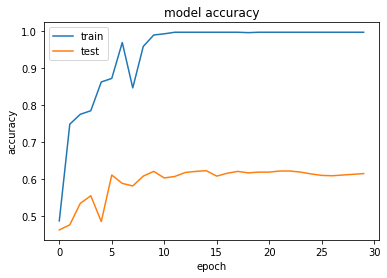

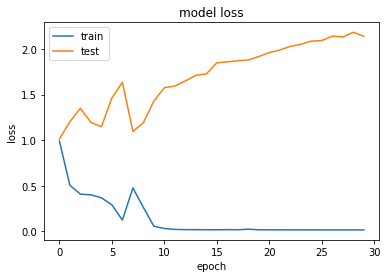

In [ ]:
plot_history(model_gru_history)

#Порівняння результатів моделей

In [ ]:
def compare_base_model_to_new_model(baseline_results, new_model_results):
  for key, value in baseline_results.items():
    print(f"Base model {key.upper()}: {value:.2f}, New model {key.upper()}: {new_model_results[key]:.2f}, Relative Improvement: {(new_model_results[key]/value-1)*100:.1f}%")

In [ ]:
baseline_results = calculate_results(y_true=val_set['Predict'],
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 44.532019704433495,
 'f1': 0.30008091726449565,
 'precision': 0.58606453653907,
 'recall': 0.44532019704433495}

In [ ]:
model_gru_results = calculate_results(y_true=val_set['Predict'],
                                    y_pred=model_gru_preds)
model_gru_results

{'accuracy': 61.47783251231527,
 'f1': 0.6053631410952326,
 'precision': 0.6134405089813897,
 'recall': 0.6147783251231527}

In [ ]:
compare_base_model_to_new_model(baseline_results, model_gru_results)

Base model ACCURACY: 44.53, New model ACCURACY: 61.48, Relative Improvement: 38.1%
Base model PRECISION: 0.59, New model PRECISION: 0.61, Relative Improvement: 4.7%
Base model RECALL: 0.45, New model RECALL: 0.61, Relative Improvement: 38.1%
Base model F1: 0.30, New model F1: 0.61, Relative Improvement: 101.7%
